# 1. HW1
### Or Wolkimir (308402163) and Afek Adler (204249239) 
This is our solution for applying 5 different architectures of LeNet5.
All configurations can be changed in the **config** section. There is no reason to manipulate other code sections.

For implementing different architectures we used pytorch build-in **nn.ModuleDict**.

**For the ease of convience for the checker, we leave the code with default args that make the model run for short time (10 epochs, with uploading weights at each epoch). Should be around 90 Seconds.** if you wish to make it shorter you can decrease the number of epochs .

The code Was written in this fashion in order to be **easily modified and extended** (more complicated scinerios) so maybe it appears to have some code overhead.

We added our graphs (for ~10 epochs and detailed explanations in the attached pdf).

The solution is also available at - https://github.com/AfekIlayAdler/UNI-2020-DeepLearning/tree/master/HW1

In [0]:
import numpy as np
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab
import torch
from torchvision import datasets, transforms
import helper
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import summary
import datetime
import pandas as pd
from collections import OrderedDict
from os import mkdir
from os.path import isdir
from glob import glob
from pathlib import Path

# 2. Model


In [0]:
def get_regulizer(experiment):
  hiden_layer_size = 120
  regulizers = nn.ModuleDict([
              ['batch_norm', nn.BatchNorm1d(hiden_layer_size, affine=False)],
              ['dropout', nn.Dropout(0.1)],
              ['no_regulizer', nn.Identity(hiden_layer_size)],
              ['weight_decay',  nn.Identity(hiden_layer_size)]])
  return regulizers[experiment]


class LeNet5(nn.Module):
  def __init__(self,regulizer):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,padding=2)
    self.max_pool_1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.max_pool_2 = nn.MaxPool2d(kernel_size=2)  
    self.fc1 = nn.Linear(16*5*5, 120) 
    self.fc2 = nn.Linear(120, 84) 
    self.fc3 = nn.Linear(84, 10) 
    self.softmax = nn.LogSoftmax(dim=1)
    self.regulizer = get_regulizer(regulizer)


  def forward(self, x):
    x = F.relu(self.conv1(x))  
    x = self.max_pool_1(x) 
    x = F.relu(self.conv2(x))
    x = self.max_pool_2(x)
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = self.regulizer(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = self.softmax(x)
    return x

# 3. Trainer

In [0]:
class Trainer:
  def __init__(self,model,tb, config):
    self.model = model
    self.model_name = config.model_name
    self.seed = config.seed
    self.lr = config.lr
    self.epochs = config.epochs
    self.save_model = config.save_model
    self.upload_model = config.upload_model
    self.model_weights_path = config.model_weights_path
    self.tb = tb
    self.weight_decay = config.weight_decay
    self.optimizer = optim.Adam(self.model.parameters(), lr = self.lr, weight_decay = self.weight_decay)
    torch.manual_seed(self.seed)
    self.criterion = nn.NLLLoss()
    self.results = {}
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
      self.model.to(self.device)

  def get_results(self):
    return pd.DataFrame.from_dict(self.results)

  def record(self,epoch,**kwargs):
    print(f"epoch # {epoch} : \n")
    for key, value in kwargs.items():
      self.tb.save_value(self.model_name, f"{self.model_name}_{key}", epoch,value)
      key = f"{self.model_name}_{key}"
      if not self.results.get(key):
        self.results[key] =[]
      self.results[key].append(value.item())
      print(f"{key} : {np.round(value,5)}")
      
  def calc_train_accuracy(self,images,labels):
    self.model.eval()
    log_ps = self.model(images)
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    self.model.train()
    return torch.mean(equals.type(torch.FloatTensor))

  def fit(self,trainloader, testloader, exp_name): 
    train_accu, test_accu = [],[]
    for epoch in range(1,self.epochs+1):
      weights_path = Path(f"{self.model_weights_path}/{config.model_name}_{epoch}.pth")
      if weights_path.exists() and self.upload_model:
        epoch_train_accuracy = self.load_checkpoint(weights_path,epoch)
      else:
        epoch_train_accuracy = self.run_epoch()
      epoch_test_accuracy = self.test(testloader)/len(testloader)
      self.record(epoch,train_accuracy = epoch_train_accuracy, test_accuracy = epoch_test_accuracy)
      self.save_checkpoint(weights_path,epoch_train_accuracy)


  def run_epoch(self):
      self.model.train()
      train_loss , train_accuracy= 0, 0
      for images, labels in trainloader:
        images = images.to(self.device)
        labels = labels.to(self.device)
        log_ps = self.model(images)
        train_accuracy += self.calc_train_accuracy(images,labels)
        loss = self.criterion(log_ps, labels)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        train_loss += loss.item()
      epoch_train_accuracy = train_accuracy/len(trainloader)
      return epoch_train_accuracy


  def test(self,test_loader):
    self.model.eval()
    test_loss,test_accuracy = 0,0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(self.device)
            labels = labels.to(self.device)
            log_ps = self.model(images)
            test_loss += self.criterion(log_ps, labels)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    return test_accuracy

  def save_checkpoint(self,weights_path,loss):
    if (not weights_path.exists()) and self.save_model: 
      torch.save({'model_state_dict': self.model.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),'loss': loss}, weights_path)
      
  def load_checkpoint(self,weights_path,epoch):
    checkpoint = torch.load(weights_path)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.model.to(self.device)
    loss = checkpoint['loss']
    print(f"Uploaded weights succesfuly at epoch number {epoch}")
    return loss

# 4. Utils
Utility functions for the code

In [0]:
class Config:  
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

  def add_attributes(self,**kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

def create_directories(l):
  for directory_path in l:
    if not (isdir(directory_path)):
      mkdir(directory_path)

def get_train_test_loaders(batch_size):
  # Define a transform to normalize the data
  transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
  # Download and load the training data
  trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
  # Download and load the test data
  testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)
  testloader = torch.utils.data.DataLoader(testset, batch_size= batch_size, shuffle=True)
  return trainloader, testloader


# 5. Configurations 

In [0]:
from google.colab import drive
drive.mount('/content/drive')
ROOT_PATH = '/content/drive/My Drive/DL/HW1/ex1_204249239_308402163/'
MODEL_WEIGHTS_DIR = 'model_weights'
GRAPHS_FOLDER_NAME = 'graphs'
model_weights_dir = f"{ROOT_PATH}{MODEL_WEIGHTS_DIR}" 
graphs_dir = f"{ROOT_PATH}{GRAPHS_FOLDER_NAME}" 

def get_base_config():
  ####################################################################
  # model consistency options
  SAVE_TO_CHECKPOINTS = False # if ture, saves model.name_epcoch file into the weights folder
  LOAD_CHECKPOINTS = True # # if ture, every epoch tries to load pretrained weights
  ####################################################################
  # if needed, can be modified to upload the 'best model'
  return Config(
          seed = 2, lr = 0.001,epochs = 10,save_model = SAVE_TO_CHECKPOINTS,
          upload_model = LOAD_CHECKPOINTS,model_weights_path = model_weights_dir)
WEIGHT_DECAY = 0.0002
EXPERIMENTS =  ['batch_norm','dropout','weight_decay','no_regulizer']  # default run: all experiments
BATCH_SIZE = 32
SAVE_FIGS = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 6. Run experiments

In [0]:
def run_exp(experiments):
  # create weights directory
  create_directories([graphs_dir,model_weights_dir])
  tb = TensorBoardColab()
  results = []
  for exp_name in experiments:
    print(f"{'#'*50} \n running {exp_name} experiment\n{'#'*50} \n") 
    weight_decay = WEIGHT_DECAY if exp_name == 'weight_decay' else 0
    config.add_attributes(weight_decay = weight_decay,model_name = exp_name)
    trainer = Trainer(LeNet5(exp_name),tb,config)
    trainer.fit(trainloader, testloader, exp_name)
    results.append(trainer.get_results())
  return results

config = get_base_config()
trainloader, testloader = get_train_test_loaders(BATCH_SIZE)
results = run_exp(EXPERIMENTS)

Wait for 8 seconds...
TensorBoard link:
http://25cf4b6b.ngrok.io
################################################## 
 running batch_norm experiment
################################################## 

Uploaded weights succesfuly at epoch number 1
epoch # 1 : 

batch_norm_train_accuracy : 0.8432499766349792
batch_norm_test_accuracy : 0.8709099888801575
Uploaded weights succesfuly at epoch number 2
epoch # 2 : 

batch_norm_train_accuracy : 0.88823002576828
batch_norm_test_accuracy : 0.8860800266265869
Uploaded weights succesfuly at epoch number 3
epoch # 3 : 

batch_norm_train_accuracy : 0.8984000086784363
batch_norm_test_accuracy : 0.8918700218200684
Uploaded weights succesfuly at epoch number 4
epoch # 4 : 

batch_norm_train_accuracy : 0.9053199887275696
batch_norm_test_accuracy : 0.8870800137519836
Uploaded weights succesfuly at epoch number 5
epoch # 5 : 

batch_norm_train_accuracy : 0.9113500118255615
batch_norm_test_accuracy : 0.8978599905967712
Uploaded weights succesfuly at epoch

# 7. Visualizing the results

<Figure size 432x288 with 0 Axes>

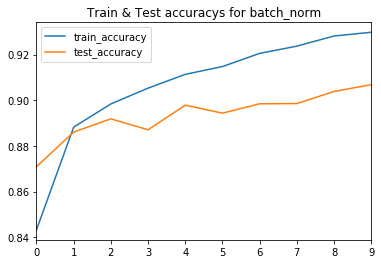

<Figure size 432x288 with 0 Axes>

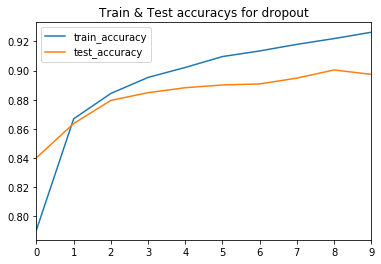

<Figure size 432x288 with 0 Axes>

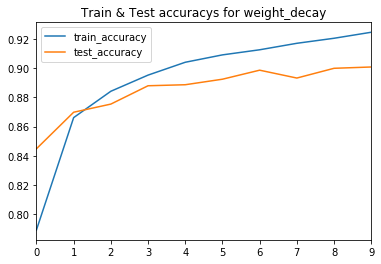

<Figure size 432x288 with 0 Axes>

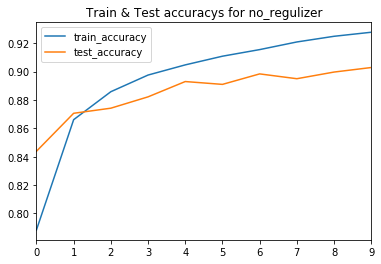

In [0]:
results_df = pd.concat(results,axis = 1)
for exp in EXPERIMENTS:
  suffixes =  ['train_accuracy','test_accuracy']
  cols = [f"{exp}_{suffix}" for suffix in suffixes]
  temp_df = results_df[cols]
  temp_df.columns =  suffixes 
  plt.figure()
  temp_df.astype(float).plot(title= F"Train & Test accuracys for {exp}")
  if SAVE_FIGS:
    plt.savefig(graphs_dir+ F"/{exp}.png")